## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: in progress
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

## Load a saved model 

This saved file includes both the model architecture and the trained weights. See the model.save() method for further details. The model was built in order to help identify patients with pneumonia. Start simply by loading the model and pulling up a summary of the layers. (To load the model use the keras.models.load_model() function.)

In [1]:
from keras import models
from keras.models import load_model
from keras.preprocessing import image
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Your code here
cnn1 = load_model('cnn1_chest_xray_ALL_data_2020-09-11.h5')
# As a reminder 
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [3]:
# Extract model layer outputs
cnn1_layer_outputs = [layer.output for layer in cnn1.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
cnn1_feature_maps = models.Model(inputs=cnn1.input, outputs=cnn1_layer_outputs)

## Load an Image

Before plotting the learned representations of the convolutional base, let's import an image and display it prior to processing. This will provide a comparison to the transformations formed by the model's feature maps.   

Load and display images `IM-0001-0001.jpeg`, `person1000_bacteria_2931.jpeg` and `person1000_virus_1681.jpeg`.

In [4]:
def show_image(input_filepath, size):
    path = input_filepath
    img = image.load_img(path, target_size=(size, size))
    plt.imshow(img)
    plt.show()

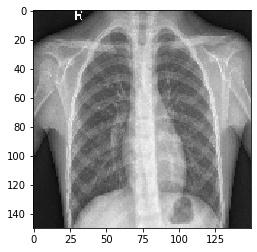

In [5]:
show_image('IM-0001-0001.jpeg', 150) # normal

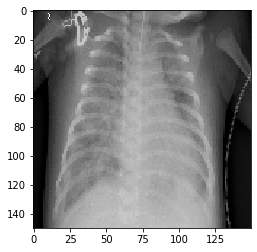

In [6]:
show_image('person1000_bacteria_2931.jpeg', 150) # bacteria

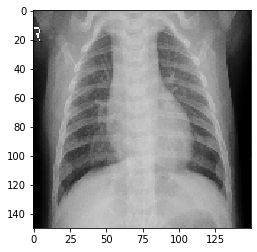

In [7]:
show_image('person1000_virus_1681.jpeg', 150) # virus

## Transform the Image to a Tensor and Visualize Again

Recall that all images are required to be preprocessed into tensors when using deep learning. As such, preprocess one image and then redisplay it interms of its tensor form.

In [8]:
# get the tensor form of input image
def transform_image2tensor(input_filepath, size, norm):
    
    path = input_filepath
    img = image.load_img(input_filepath, target_size=(size, size))
    file_tensor = image.img_to_array(img)
    file_tensor = np.expand_dims(file_tensor, axis=0)
    
    # Follow the Original Model Preprocessing
    file_tensor /= norm
    
    # Check tensor shape
    print(file_tensor.shape)
    
    # Preview an image
    plt.imshow(file_tensor[0])
    plt.show()
    
    return file_tensor

(1, 150, 150, 3)


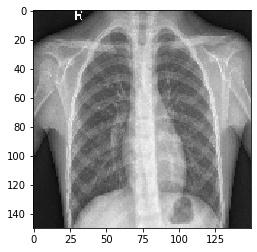

In [9]:
normal_tensor = transform_image2tensor('IM-0001-0001.jpeg', 150, 255) # normal

(1, 150, 150, 3)


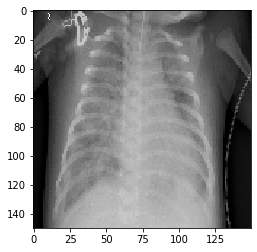

In [10]:
bacteria_tensor = transform_image2tensor('person1000_bacteria_2931.jpeg', 150, 255) # bacteria

(1, 150, 150, 3)


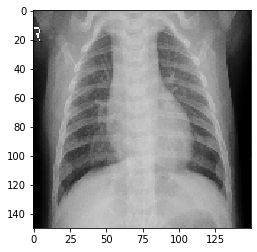

In [11]:
virus_tensor = transform_image2tensor('person1000_virus_1681.jpeg', 150, 255) # virus

In [12]:
# get activations' featured maps over all layers of the trained model
def retrieve_file_activations(input_file_tensor, trained_model, trained_feature_maps, layer_activation, channel_layer):
    
    # Returns an array for each activation layer
    activations = trained_feature_maps.predict(input_file_tensor)

    layer = activations[layer_activation]
    print('layer',layer_activation,' '+trained_model.layers[layer_activation].name+': dimension=',layer.shape)

    # We slice the third channel and preview the results
    plt.matshow(layer[0, :, :, channel_layer], cmap='viridis')
    plt.show()
    
    return activations

layer 3  max_pooling2d_1: dimension= (1, 36, 36, 64)


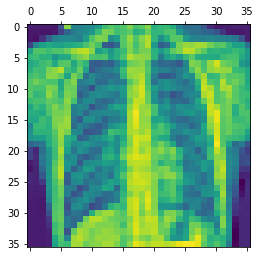

In [13]:
# We slice the third channel and preview the results
normal_activations = retrieve_file_activations(normal_tensor, cnn1, cnn1_feature_maps, 3, 28)

layer 3  max_pooling2d_1: dimension= (1, 36, 36, 64)


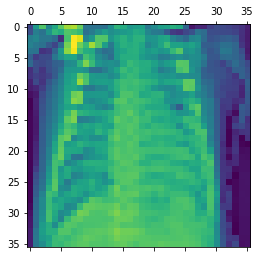

In [14]:
bacteria_activations = retrieve_file_activations(bacteria_tensor, cnn1, cnn1_feature_maps, 3, 28)

layer 3  max_pooling2d_1: dimension= (1, 36, 36, 64)


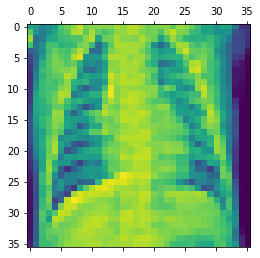

In [15]:
virus_activations = retrieve_file_activations(virus_tensor, cnn1, cnn1_feature_maps, 3, 28)

layer 0  conv2d: dimension= (1, 148, 148, 32)


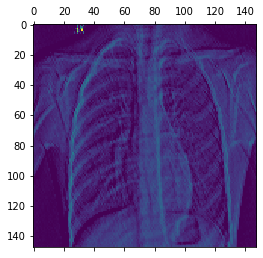

In [16]:
# Repeating the process for another channel (the 30th)
normal_activations = retrieve_file_activations(normal_tensor, cnn1, cnn1_feature_maps, 0, 30)

layer 0  conv2d: dimension= (1, 148, 148, 32)


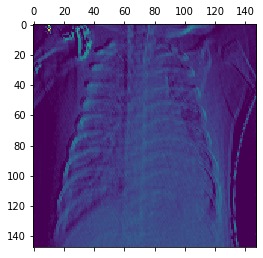

In [17]:
bacteria_activations = retrieve_file_activations(bacteria_tensor, cnn1, cnn1_feature_maps, 0, 30)

layer 0  conv2d: dimension= (1, 148, 148, 32)


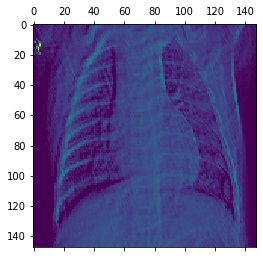

In [18]:
virus_activations = retrieve_file_activations(virus_tensor, cnn1, cnn1_feature_maps, 0, 30)

## Plot Feature Maps

Now that a model has been loaded, perform visualizing each of the channels for each of feature maps of the convolutional layers. Recall that this process will take a few steps. First, extract the feature maps, or layer outputs from each of the activation functions in the model. From there, generate models that transform the image from its raw state to these feature maps. These transformations are taken, and each channel for each feature map is visualized, accordingly.  

In [19]:
# display each activation's 
def show_feature_maps(trained_model, activations, output_filename):
    # Extract Layer Names for Labelling
    layer_names = []
    for layer in trained_model.layers[:8]:
        layer_names.append(layer.name)

    total_features = sum([a.shape[-1] for a in activations])
    print(total_features)

    n_cols = 16
    n_rows = math.ceil(total_features / n_cols)

    iteration = 0
    fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

    for layer_n, layer_activation in enumerate(activations):
        channel_layer = layer_activation.shape[-1]
        print('layer',layer_n,': channel numbers=',channel_layer)
        
        for ch_idx in range(channel_layer):
            row = iteration // n_cols
            column = iteration % n_cols
    
            ax = axes[row, column]
            channel_image = layer_activation[0, :, :, ch_idx]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            ax.imshow(channel_image, aspect='auto', cmap='viridis')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
        
            if ch_idx == 0:
                ax.set_title(layer_names[layer_n], fontsize=10)
        
            iteration += 1

    fig.subplots_adjust(hspace=1.25)
    plt.savefig('CNN_Intermediate_Activations_Visualized_'+output_filename+'.pdf')
    plt.show()

704
layer 0 : channel numbers= 32


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


layer 1 : channel numbers= 32
layer 2 : channel numbers= 64
layer 3 : channel numbers= 64
layer 4 : channel numbers= 128
layer 5 : channel numbers= 128
layer 6 : channel numbers= 128
layer 7 : channel numbers= 128


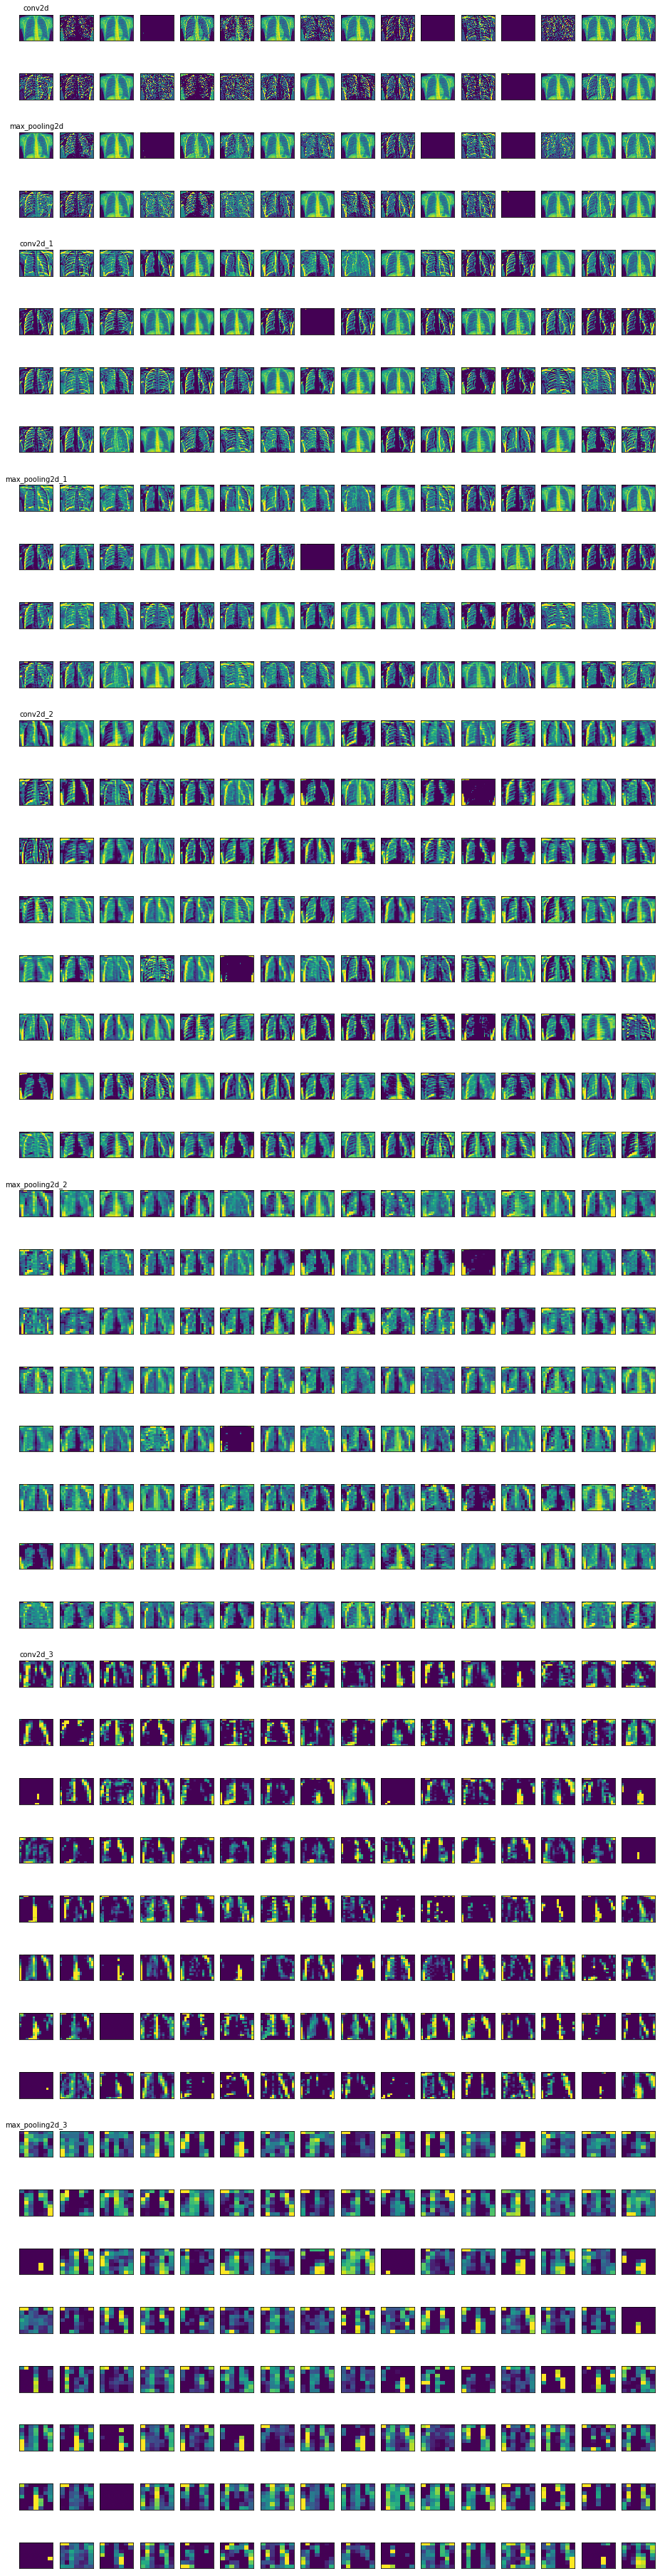

In [20]:
show_feature_maps(cnn1, normal_activations, 'normal')

704
layer 0 : channel numbers= 32
layer 1 : channel numbers= 32
layer 2 : channel numbers= 64
layer 3 : channel numbers= 64
layer 4 : channel numbers= 128
layer 5 : channel numbers= 128
layer 6 : channel numbers= 128


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


layer 7 : channel numbers= 128


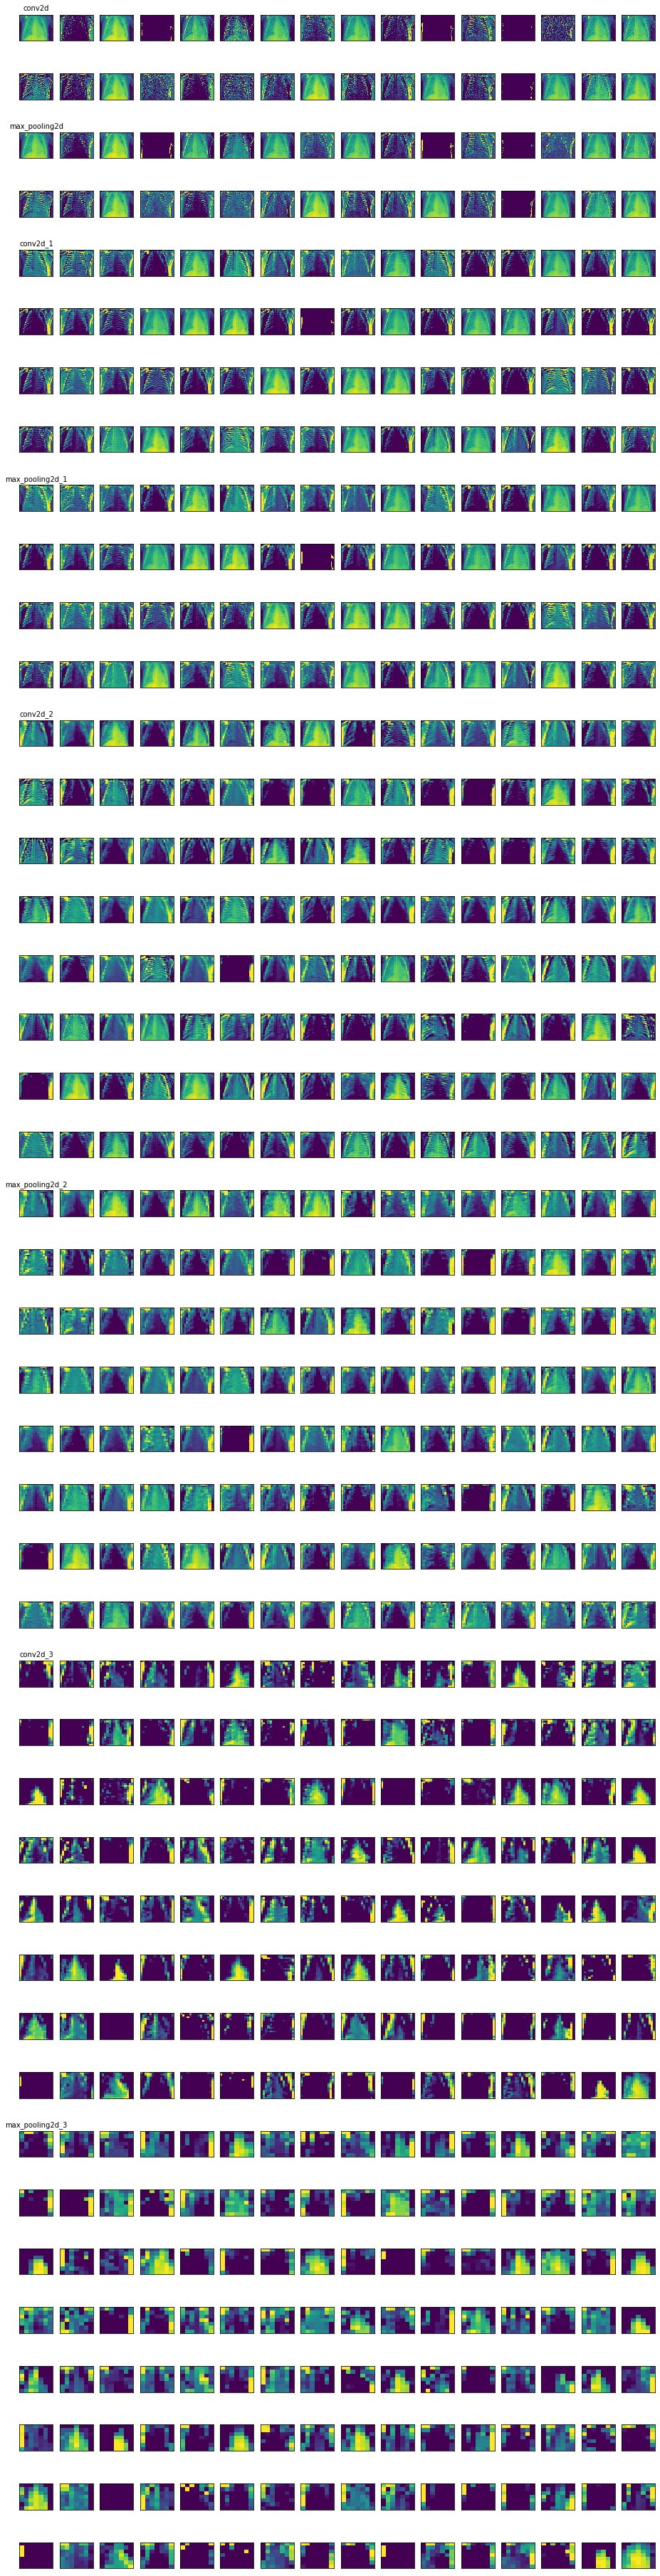

In [21]:
show_feature_maps(cnn1, bacteria_activations, 'bacteria')

704
layer 0 : channel numbers= 32
layer 1 : channel numbers= 32
layer 2 : channel numbers= 64
layer 3 : channel numbers= 64
layer 4 : channel numbers= 128
layer 5 : channel numbers= 128
layer 6 : channel numbers= 128


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


layer 7 : channel numbers= 128


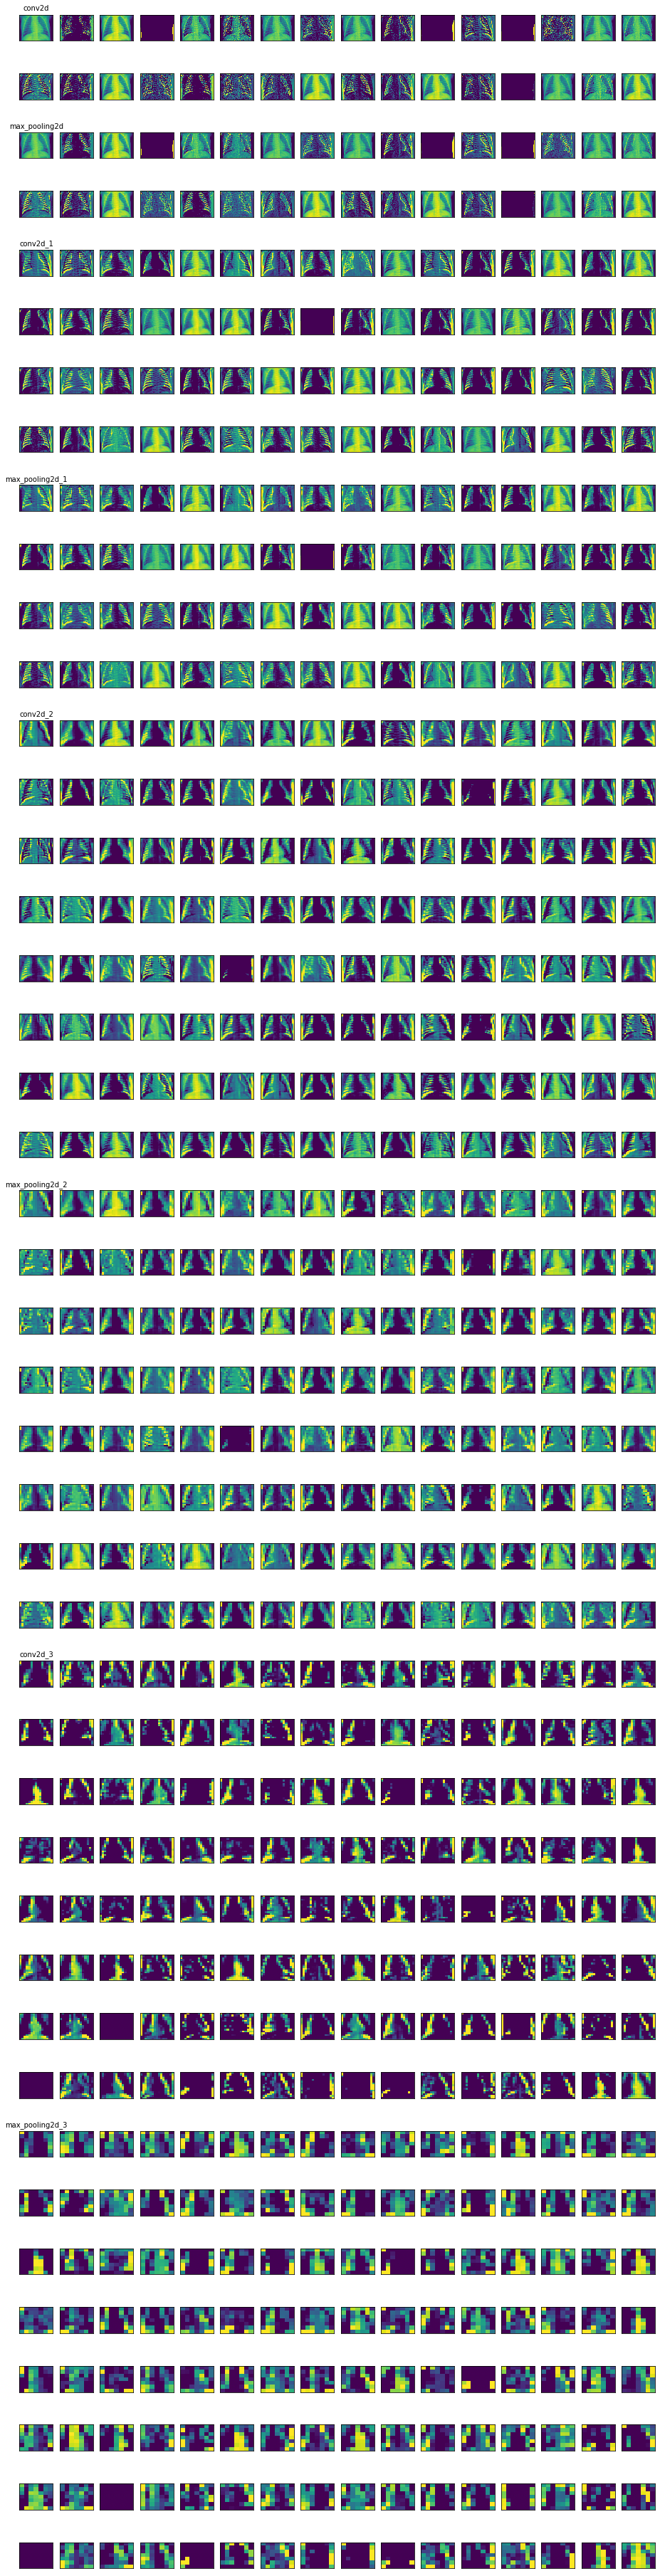

In [22]:
show_feature_maps(cnn1, virus_activations, 'virus')